Обработка исходных данных и формирование обучающей/тестовой выборки

# Загрузка библиотек

In [21]:
import hashlib
import imagehash
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import seaborn as sns
import albumentations as A
from tqdm import tqdm
from PIL import Image
from collections import Counter

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Подготовка файла с разметкой

In [3]:
path_data = Path('../data/receipt_screen_data/')

In [4]:
filenames = []
for folder in os.listdir(path_data):
    filenames.extend(
        [(path_data / folder / x).__str__() for x in os.listdir(path_data / folder)]
    )
classes = [filename.split('\\')[-2] for filename in filenames]

In [5]:
df_markup = pd.DataFrame(data={
    'filename': filenames,
    'class': classes
})

In [6]:
df_markup['class'].unique()

array(['new_terminals', 'other', 'pc_screens', 'pc_screen_augm',
       'rack_new_terminal', 'receipts', 'stickers', 'terminals',
       'terminals_receipt', 'terminals_side_view'], dtype=object)

In [7]:
def check(x):
    if 'receipt' in x:
        return 'receipt'
    if 'pc_screen' in x:
        return 'pc_screen'
    return 'other'

In [8]:
df_markup['target'] = df_markup['class'].apply(lambda x: check(x))

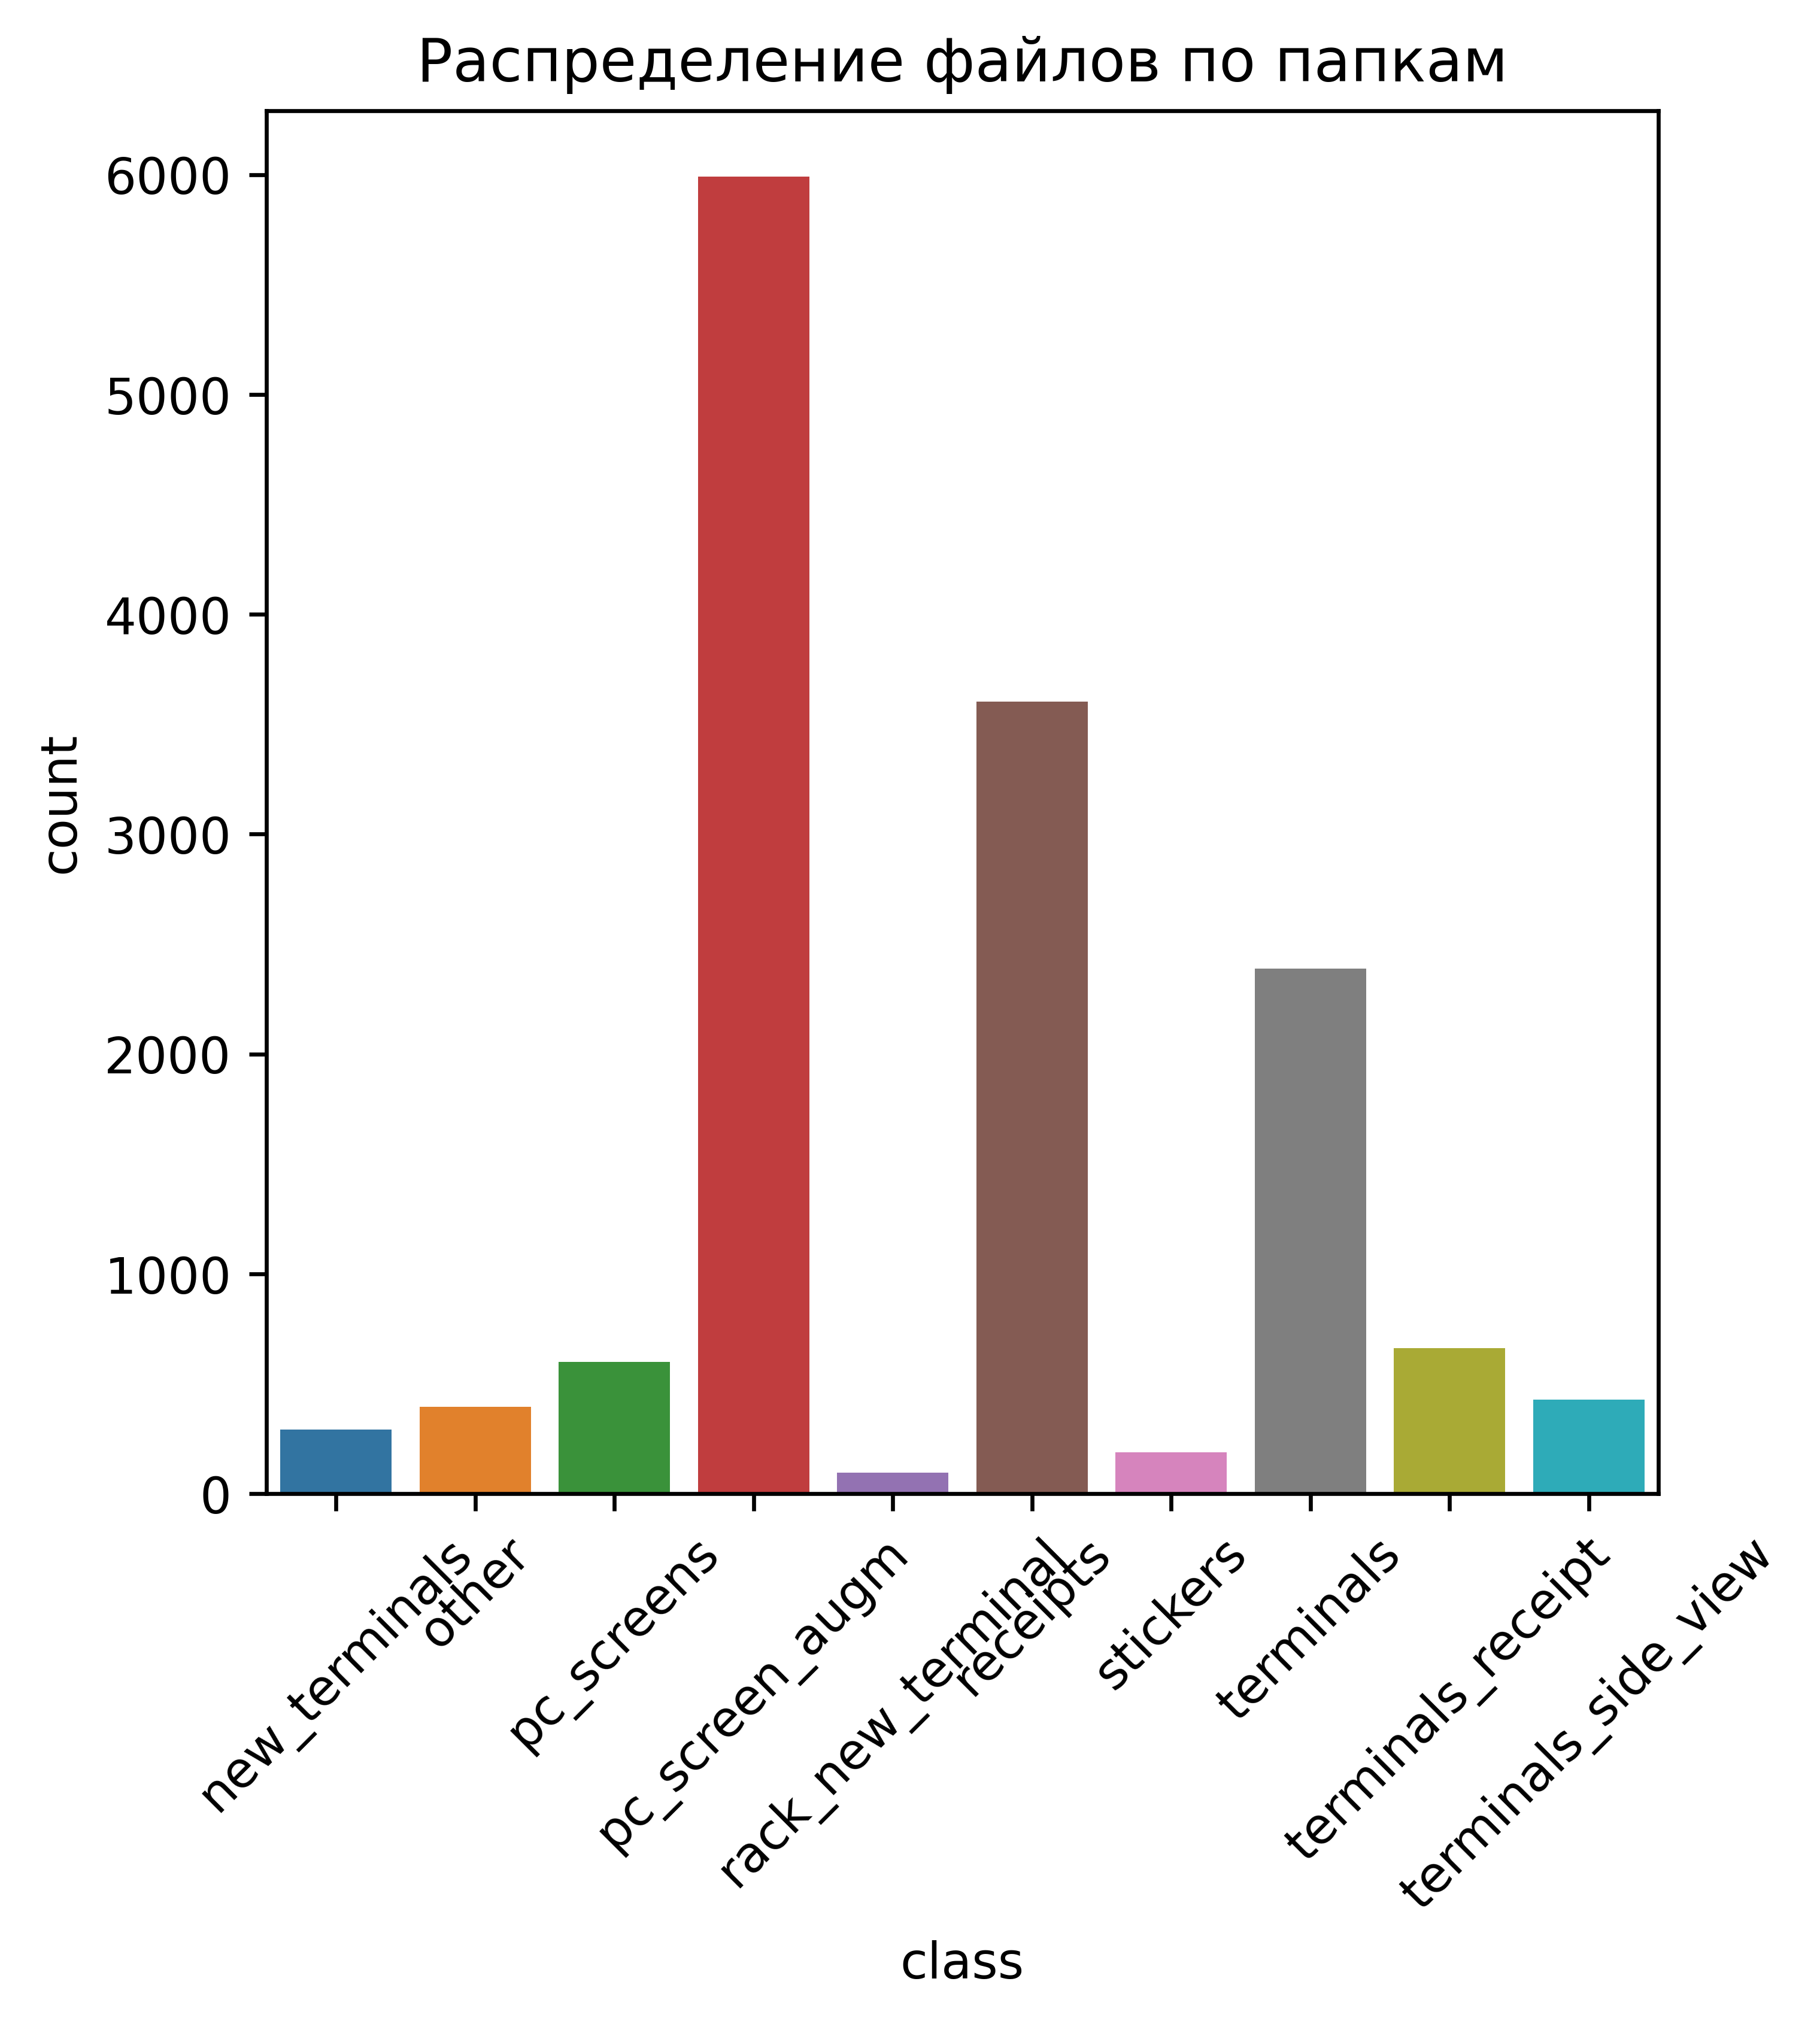

In [9]:
plt.figure(figsize=(5,5), dpi=600)
sns.countplot(df_markup, x=df_markup['class'])
plt.title('Распределение файлов по папкам')
plt.xticks(rotation=45)
plt.show()

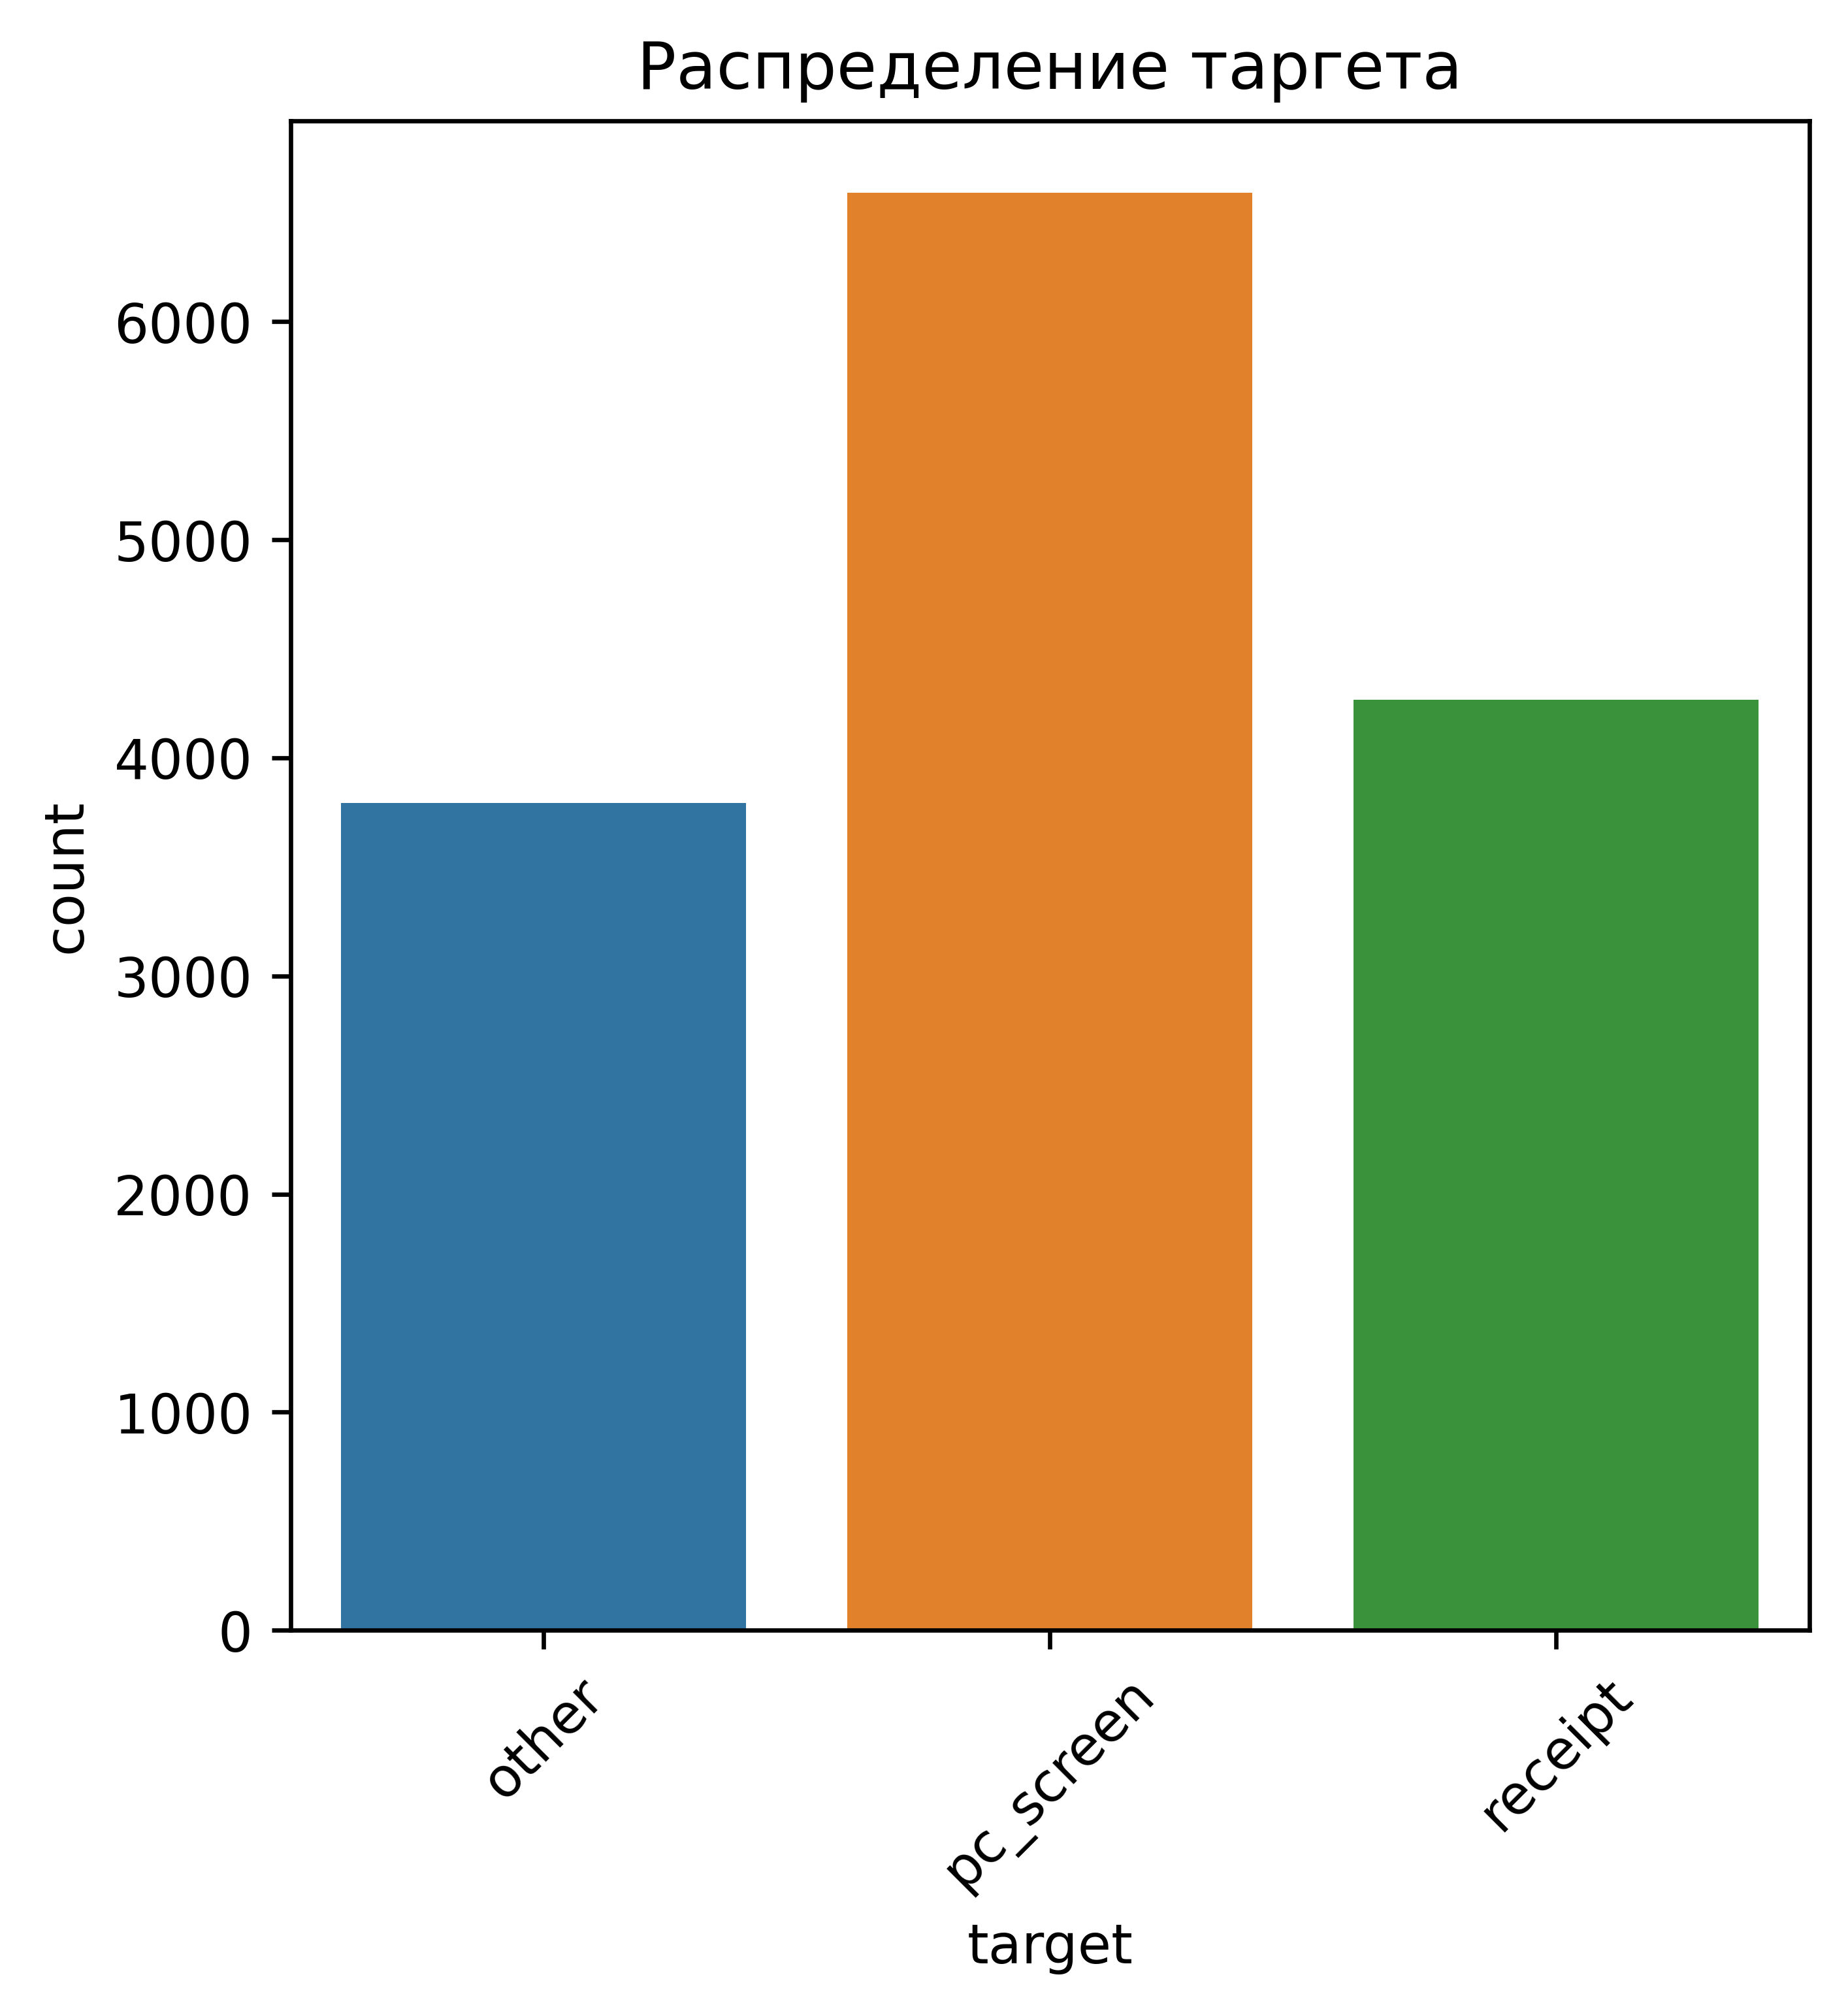

In [10]:
plt.figure(figsize=(5,5), dpi=600)
sns.countplot(df_markup, x=df_markup['target'])
plt.title('Распределение таргета')
plt.xticks(rotation=45)
plt.show()

# Аугментации картинок с экранами

In [11]:
path_screen_augm = path_data / 'pc_screen_augm'
if not os.path.exists(path_screen_augm):
    os.makedirs(path_screen_augm)

In [12]:
trans_contrast = A.RandomBrightnessContrast(
        always_apply=True,
        contrast_limit=(-.6, -.6),
        p=1
    )
trans_spat = A.Spatter(
        always_apply=True, mean=-0.79,
        std=13.16, p=1
    )

trans_clache = A.CLAHE(
        always_apply=True,
        p=1
    )

trans_emboss = A.Emboss(
    always_apply=True,
    p=1
)

trans_sharp = A.Sharpen(
    always_apply=True,
    p=1
)

trans_gauss_noise = A.GaussNoise(
    always_apply=True,
    p=1
)

trans_hue_sat = A.HueSaturationValue(
    always_apply=True,
    hue_shift_limit=(-20, 20),
    sat_shift_limit=(-30, 30),
    val_shift_limit=(-20, 20),
    p=1
)

trans_color_jitter = A.ColorJitter(
    always_apply=True,
    brightness=0.2,
    contrast=0.2,
    saturation=0.2,
    hue=0.2,
    p=1
)

trans_rotation = A.RandomRotate90(
    always_apply=True, p=1
)

compose1 = A.Compose(
    [trans_contrast, trans_spat, trans_color_jitter]
)

compose2 = A.Compose(
    [trans_contrast, trans_spat, trans_gauss_noise]
)

compose3 = A.Compose(
    [trans_color_jitter, trans_spat, trans_sharp]
)

compose4 = A.Compose(
    [trans_color_jitter, trans_spat, trans_hue_sat]
)

compose5 = A.Compose(
    [trans_hue_sat, trans_spat, trans_sharp]
)

compose6 = A.Compose(
    [trans_gauss_noise, trans_spat]
)

compose7 = A.Compose(
    [trans_rotation, trans_gauss_noise, trans_spat, trans_sharp]
)

compose8 = A.Compose(
    [trans_rotation, trans_gauss_noise, trans_hue_sat, trans_sharp]
)

compose9 = A.Compose(
    [trans_rotation, trans_color_jitter, trans_spat, trans_sharp, trans_hue_sat]
)

compose10 = A.Compose(
    [trans_emboss, trans_gauss_noise, trans_spat]
)

In [13]:
composes = [compose1, compose2, compose3, compose4, compose5, compose6, compose7, compose8, compose9, compose10]

In [14]:
df_screen = df_markup.loc[
        df_markup['target']=='pc_screen'
    ]

In [91]:
for filepath in tqdm(df_screen.loc['filename']):
    filename = filepath.split('\\')[-1]
    shortname = filename.split('.')[0]
    image = np.array(Image.open(filepath))
    for i, compose in enumerate(composes):
        image_augm = compose(image=image)['image']
        im = Image.fromarray(image_augm)
        im.save(path_screen_augm / f'{shortname}_augm{i}.jpeg')

100%|██████████| 316/316 [22:05<00:00,  4.20s/it]


# Сохранение данных об аугментациях

In [15]:
df_augm = pd.DataFrame({
    'filename': [(path_screen_augm / x).__str__() for x in os.listdir(path_screen_augm)],
    'class': ['screen_augm' for _ in os.listdir(path_screen_augm)],
    'target': ['pc_screen' for _ in os.listdir(path_screen_augm)]
})
df_markup = pd.concat((df_markup, df_augm))
df_markup.reset_index(drop=True, inplace=True)

# Фильтрация одинаковых/похожих картинок

In [16]:
def phash(filename) -> str:
    image = Image.open(filename)
    hash_size: int=8
    return str(
        hashlib.sha256(
            bytearray(
                imagehash.phash(
                    image, hash_size=hash_size
                ).hash.flatten().astype(int).tolist())
            ).hexdigest())

In [18]:
hashes = []
for filename in tqdm(df_markup['filename']):
    file_hash = phash(filename)
    hashes.append(file_hash)

100%|██████████| 20638/20638 [11:59<00:00, 28.69it/s]


In [22]:
df_markup['hash'] = hashes
df_markup.sort_values(by='hash', inplace=True)

df_markup['hash'] = hashes
counter = Counter(df_markup['hash'])
df_hashes = pd.DataFrame(
    {
        'hash': list(counter.keys()),
        'count': list(counter.values())
    }
)
n_dupl = df_hashes[df_hashes['count']>1]['count'].sum()
print(f'Количество фото с дубликатами: {n_dupl}')

Количество фото с дубликатами: 13102


In [25]:
df_markup.drop_duplicates(subset=['hash'], inplace=True)
df_markup.reset_index(inplace=True, drop=True)
df_markup.to_pickle('df_markup.pkl')